# Notebook for generating and saving SBM PATTERN graphs

In [2]:
import numpy as np
import torch
import pickle
import time
import networkx as nx
# %matplotlib inline
import matplotlib.pyplot as plt
import scipy.sparse


# Generate SBM PATTERN graphs

In [44]:

def schuffle(W,c):
    # relabel the vertices at random
    idx=np.random.permutation( W.shape[0] )
    #idx2=np.argsort(idx) # for index ordering wrt classes
    W_new=W[idx,:]
    W_new=W_new[:,idx]
    c_new=c[idx]
    return W_new , c_new , idx 


def block_model(c,p,q):
    n=len(c)
    W=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if c[i]==c[j]:
                prob=p
            else:
                prob=q
            if np.random.binomial(1,prob)==1:
                W[i,j]=1
                W[j,i]=1     
    return W


def unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q):  
    c = []
    for r in range(nb_of_clust):
        if clust_size_max==clust_size_min:
            clust_size_r = clust_size_max
        else:
            clust_size_r = np.random.randint(clust_size_min,clust_size_max,size=1)[0]
        val_r = np.repeat(r,clust_size_r,axis=0)
        c.append(val_r)
    c = np.concatenate(c)  
    W = block_model(c,p,q)  
    return W,c


def random_pattern(n,p):
    W=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if np.random.binomial(1,p)==1:
                W[i,j]=1
                W[j,i]=1     
    return W    


    
def add_pattern(W0,W,c,nb_of_clust,q):
    n=W.shape[0]
    n0=W0.shape[0]
    V=(np.random.rand(n0,n) < q).astype(float)
    W_up=np.concatenate(  ( W , V.T ) , axis=1 )
    W_low=np.concatenate( ( V , W0  ) , axis=1 )
    W_new=np.concatenate( (W_up,W_low)  , axis=0)
    c0=np.full(n0,nb_of_clust)
    c_new=np.concatenate( (c, c0),axis=0)
    return W_new,c_new


class generate_SBM_graph():

    def __init__(self, SBM_parameters): 

        # parameters
        nb_of_clust = SBM_parameters['nb_clusters']
        clust_size_min = SBM_parameters['size_min']
        clust_size_max = SBM_parameters['size_max']
        p = SBM_parameters['p']
        q = SBM_parameters['q']
        p_pattern = SBM_parameters['p_pattern']
        q_pattern = SBM_parameters['q_pattern']
        vocab_size = SBM_parameters['vocab_size']
        W0 = SBM_parameters['W0']
        u0 = SBM_parameters['u0']

        # block model
        W, c = unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q)
        
        # signal on block model
        u = np.random.randint(vocab_size, size=W.shape[0])
        
        # add the subgraph to be detected
        W, c = add_pattern(W0,W,c,nb_of_clust,q_pattern)
        u = np.concatenate((u,u0),axis=0)
        
        # shuffle
        W, c, idx = schuffle(W,c)
        u = u[idx]
    
        # target
        target = (c==nb_of_clust).astype(float)
        
        # convert to pytorch
        W = torch.from_numpy(W)
        W = W.to(torch.int8)
        idx = torch.from_numpy(idx) 
        idx = idx.to(torch.int16)
        u = torch.from_numpy(u) 
        u = u.to(torch.int16)                      
        target = torch.from_numpy(target)
        target = target.to(torch.int16)
        
        # attributes
        self.nb_nodes = W.size(0)
        self.W = W
        self.rand_idx = idx
        self.node_feat = u
        self.node_label = target
        
        
# configuration
SBM_parameters = {}
SBM_parameters['nb_clusters'] = 10
SBM_parameters['size_min'] = 5
SBM_parameters['size_max'] = 15 # 25
SBM_parameters['p'] = 0.5 # 0.5
SBM_parameters['q'] = 0.25 # 0.1
SBM_parameters['p_pattern'] = 0.5 # 0.5
SBM_parameters['q_pattern'] = 0.25 # 0.1    
SBM_parameters['vocab_size'] = 3
SBM_parameters['size_subgraph'] = 10
SBM_parameters['W0'] = random_pattern(SBM_parameters['size_subgraph'],SBM_parameters['p_pattern'])
SBM_parameters['u0'] = np.random.randint(SBM_parameters['vocab_size'],size=SBM_parameters['size_subgraph'])
        
print(SBM_parameters)



data = generate_SBM_graph(SBM_parameters)

print(data)
#print(data.nb_nodes)
#print(data.W)
#print(data.rand_idx)
#print(data.node_feat)
#print(data.node_label)


{'nb_clusters': 10, 'size_min': 5, 'size_max': 15, 'p': 0.5, 'q': 0.25, 'p_pattern': 0.5, 'q_pattern': 0.25, 'vocab_size': 3, 'size_subgraph': 10, 'W0': array([[0., 0., 0., 0., 1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0., 0.]]), 'u0': array([0, 0, 0, 2, 1, 2, 1, 2, 2, 1])}


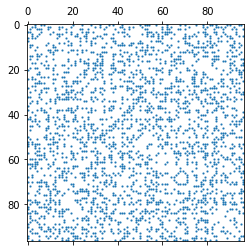

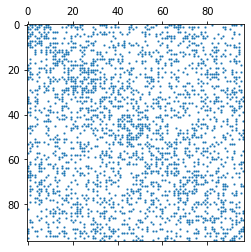

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], dtype=torch.int16)


In [45]:
#Plot Adj matrix

W = data.W
plt.spy(W,precision=0.01, markersize=1)
plt.show()

idx = np.argsort(data.rand_idx) 
W = data.W
W2 = W[idx,:]
W2 = W2[:,idx]
plt.spy(W2,precision=0.01, markersize=1)
plt.show()

target = data.node_label
target = target[idx]
print(target)


{'nb_clusters': 5, 'size_min': 5, 'size_max': 35, 'p': 0.5, 'q': 0.2, 'p_pattern': 0.5, 'q_pattern': 0.5, 'vocab_size': 3, 'size_subgraph': 20}
pattern: 0
pattern: 1
pattern: 2
pattern: 3
pattern: 4
pattern: 5
pattern: 6
pattern: 7
pattern: 8
pattern: 9
100 100 100
Time (sec): 111.08463740348816


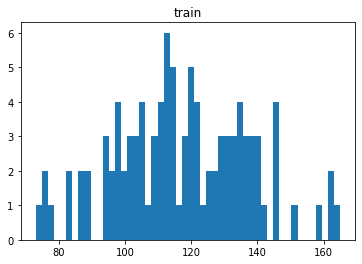

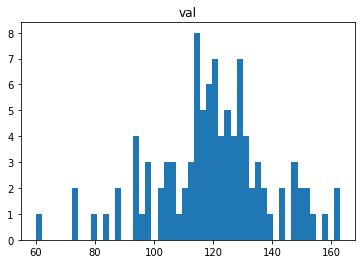

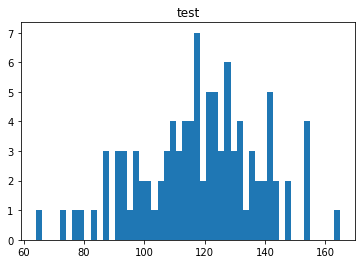

In [46]:
# Generate and save SBM graphs

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph.nb_nodes)
    plt.figure(1)
    plt.hist(graph_sizes, bins=50)
    plt.title(title)
    plt.show()

    


start = time.time()


# configuration for 100 patterns 100/20 
nb_pattern_instances = 10 # nb of patterns
nb_train_graphs_per_pattern_instance = 10 # train per pattern
nb_test_graphs_per_pattern_instance = 10 # test, val per pattern
SBM_parameters = {}
SBM_parameters['nb_clusters'] = 5 
SBM_parameters['size_min'] = 5 
SBM_parameters['size_max'] = 35 
SBM_parameters['p'] = 0.5 
SBM_parameters['q'] = 0.2 
SBM_parameters['p_pattern'] = 0.5 
SBM_parameters['q_pattern'] = 0.5  
SBM_parameters['vocab_size'] = 3 
SBM_parameters['size_subgraph'] = 20 
print(SBM_parameters)
    

dataset_train = []
dataset_val = []
dataset_test = []
for idx in range(nb_pattern_instances):
    
    print('pattern:',idx)
    
    SBM_parameters['W0'] = random_pattern(SBM_parameters['size_subgraph'],SBM_parameters['p'])
    SBM_parameters['u0'] = np.random.randint(SBM_parameters['vocab_size'],size=SBM_parameters['size_subgraph'])
    
       
    for _ in range(nb_train_graphs_per_pattern_instance):
        data = generate_SBM_graph(SBM_parameters)
        
        
        
        
        
        
        
        
        
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset_train.append(graph)

    for _ in range(nb_test_graphs_per_pattern_instance):
        data = generate_SBM_graph(SBM_parameters)
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset_val.append(graph)

    for _ in range(nb_test_graphs_per_pattern_instance):
        data = generate_SBM_graph(SBM_parameters)
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset_test.append(graph)


print(len(dataset_train),len(dataset_val),len(dataset_test))


plot_histo_graphs(dataset_train,'train')
plot_histo_graphs(dataset_val,'val')
plot_histo_graphs(dataset_test,'test')


with open('SBM_PATTERN_train.pkl',"wb") as f:
    pickle.dump(dataset_train,f)
    
    
with open('SBM_PATTERN_train.pkl', 'rb') as f:
    data = pickle.load(f)

    #  W_list = list(map(lambda d: d['W'].numpy(), data))
W_lists = list(map(lambda d: d['W'].numpy(), data))
rand_idx_list = list(map(lambda d: d['rand_idx'], data))
node_feat_list = list(map(lambda d: d['node_feat'], data))
node_label_list = list(map(lambda d: d['node_label'].numpy(), data))


class ProgressSmoothing:
    def __init__(self, g_nx):
        self.g_nx = g_nx

    def _get_weight_list(self, a, m, neighbor_list_dict):
        denominator = 0
        weight_list = [0 for _ in range(m)]
        for h in range(0, m):
            weighting = np.power(a, (m - h))
            # print(len(neighbor_list_dict[h]))
            num_nodes = len(neighbor_list_dict[h])
            weight_list[h] = weighting * num_nodes

            #             print(weighting, "@")
            #             print(num_nodes, "#")
            denominator += weighting * num_nodes
        #         print(type(denominator))
        #         print(type(weight_list))
        #        print(weight_list/denominator)
        return weight_list / denominator

    def nei_dict(self, hop_dict):
        neighbor_list_dict = {}  # neighbor_list_dict = {which_hop: [index1, index5, ....]}
        for u, h in hop_dict.items():  # hop_dict = {neighbor_id : which_hop}
            if not h in neighbor_list_dict.keys():
                n_list = [u]  # include self node
                neighbor_list_dict[h] = n_list
            else:
                neighbor_list_dict[h].append(u)
        return neighbor_list_dict

    def get_neigh_smooth_weight(self, v, a):
        #         hop_dict = nx.single_source_shortest_path_length(self.g_nx, v)
        hop_dict = nx.single_source_shortest_path_length(self.g_nx, v, 2)
        neighbor_list_dict = self.nei_dict(hop_dict)
        #         print(neighbor_list_dict)
        m = np.max(list(neighbor_list_dict.keys()))
        weight_list = self._get_weight_list(a, m, neighbor_list_dict)
        # print(weight_list)
        nidx_weight_list = []
        for h in range(0, m):
            for u in neighbor_list_dict[h]:
                nidx_weight_list.append((int(u), weight_list[h]))
        return nidx_weight_list

    def smooth_all(self, a, labels):
        total_nidx_weight_list = []
        for v in list(g_nx.nodes):
            # print(v)
            nidx_weight_list = self.get_neigh_smooth_weight(v, a)
            # print(nidx_weight_list)
            total_nidx_weight_list.extend(nidx_weight_list)
        smoothed_labels = labels.copy()
        smoothed_labels = smoothed_labels.astype(float)
        for u, w in total_nidx_weight_list:
            smoothed_labels[u] *= float(w)
        return smoothed_labels


train_label = []
for W, labels in zip(W_lists, node_label_list):
    # train_W =[]
    #    W = W.numpy()
    #    labels = node_label_list.numpy()
    g_nx = nx.from_numpy_matrix(W)
    ps = ProgressSmoothing(g_nx=g_nx)
    # train_W.append(W)
    train_label.append(ps.smooth_all(2, labels))

node_label = train_label

# new_data = [{'W':W, 'rand_idx': rand_idx, 'node_feat': node_feat, 'node_label': node_label}
#         for W, rand_idx, node_feat, node_label in zip(W_list, rand_idx_list, node_feat_list, node_label)]

for idx, smoothed_label in enumerate(node_label):
    data[idx]['node_label'] = torch.tensor(smoothed_label)

# ps = ProgressSmoothing(g_nx=g_nx)
# smoothed_labels = ps.smooth_all(2, labels)

# with open('new_SBM_CLUSTER_train_0402_03_dataset.pkl', 'wb') as f:
#     pickle.dump(data, f)
#
# with open('smoothed_SBM_CLUSTER_0406', 'wb') as f:
#     pickle.dump(data, f)


data = dataset_train



with open('SBM_PATTERN_train.pkl', "wb") as f:
    pickle.dump(dataset_train, f)
    

    
with open('SBM_PATTERN_val.pkl',"wb") as f:
    pickle.dump(dataset_val,f)
with open('SBM_PATTERN_test.pkl',"wb") as f:
    pickle.dump(dataset_test,f)
    
    
print('Time (sec):',time.time() - start) # 163s


# Convert to DGL format and save with pickle

In [47]:
import os
#os.chdir('./Users/user/Desktop/project/benchmarking_gnns') # go to root folder of the project
print(os.getcwd())


C:\Users\user\Desktop\project\benchmarking_gnns


In [21]:

import pickle

%load_ext autoreload
%autoreload 2

from data.SBMs import SBMsDatasetDGL 

from data.data import LoadData
from torch.utils.data import DataLoader
from data.SBMs import SBMsDataset, SmoothedSBMsDataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
DATASET_NAME = 'SBM_PATTERN'
dataset = SBMsDatasetDGL(DATASET_NAME) # 4424s = 73min


[I] Loading data ...


FileNotFoundError: [Errno 2] No such file or directory: 'data/SBMs\\SBM_PATTERN_train.pkl'

In [30]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])


NameError: name 'dataset' is not defined

In [21]:
start = time.time()

with open('SBM_PATTERN.pkl','wb') as f:
        pickle.dump([dataset.train,dataset.val,dataset.test],f)
        
print('Time (sec):',time.time() - start) # 21s


NameError: name 'dataset' is not defined

In [12]:
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

# Test load function

In [23]:
DATASET_NAME = 'SBM_CLUSTER_a4'
dataset = LoadData(DATASET_NAME) # 30s
trainset, valset, testset = dataset.train, dataset.val, dataset.test


[I] Loading dataset SBM_CLUSTER_a4...
C:\Users\user\Desktop\project\benchmarking_gnns
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 23.5031s


In [28]:
start = time.time()

batch_size = 10
collate = SmoothedSBMsDataset.collate
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)

print('Time (sec):',time.time() - start) #0.0006

KeyboardInterrupt: 

In [27]:
for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(train_loader):
    a = []


TypeError: collate() missing 1 required positional argument: 'samples'